In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate
from sklearn.utils import shuffle

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from tensorflow.python.client import device_lib
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)

2024-07-26 12:29:54.109986: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-26 12:29:54.477523: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-07-26 12:29:54.477872: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-26 12:29:54.480162: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-26 12:29:54.482152: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2024-07-26 12:29:54.482556: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2024-07-26 12:29:54.484553: I tensorflow/stream_executor

In [3]:
#Reading files into a log
import sys
import logging

nblog = open("nb_ht.log", "a+")
sys.stdout.echo = nblog
sys.stderr.echo = nblog

get_ipython().log.handlers[0].stream = nblog
get_ipython().log.setLevel(logging.INFO)

%autosave 5

Autosaving every 5 seconds


In [4]:
class ConvScaleShift(keras.layers.Layer):
    def __init__(self, channels, filters, kernel_size, trable = False, conv_trable = False, **kwargs):
        super(ConvScaleShift, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding='same', trainable=conv_trable)

        self.shift = self.add_weight(name='shift', shape=(filters), 
                                     initializer='zeros', trainable=True)
        self.scale = self.add_weight(name='scale', shape=(1, 1, channels, filters), 
                                     initializer='ones', trainable=True)
        self.trable = trable
        self.act = keras.activations.relu
        self.conv_trable = conv_trable
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shift': self.shift,
            'scale': self.scale,
            'trable': self.trable,
            'act': self.act,
        })
        return config
        
    # Defines the computation
    def call(self, inputs):
        if self.trable == False:
            x = self.conv(inputs)
            x = self.act(x)
            return x
        else:
            y = self.conv(inputs)
            oldw = self.non_trainable_weights[-2]
            oldb = self.non_trainable_weights[-1]
            neww = tf.multiply(oldw, self.scale) 
            newb = tf.add(oldb, self.shift)
            x = tf.nn.conv2d(inputs, neww, strides = 1, padding='SAME') + newb            
            x = self.act(x)
            return x

In [5]:
#Defining the CWoLA model
def CWoLA(p_i, trable = False, conv_trable = False):
    
    input_1 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_1")
    y = keras.layers.BatchNormalization()(input_1)
    input_2 = keras.layers.Input(shape = (p_i,p_i,1), name = "jet_2")
    z = keras.layers.BatchNormalization()(input_2)
    
    cnn = keras.Sequential([
        ConvScaleShift(1 , 64, (5,5), trable = trable, conv_trable = conv_trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 64, (5,5), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2), trainable = conv_trable),
        ConvScaleShift(64, 128, (3,3), trable = trable),
        keras.layers.MaxPool2D(pool_size = (2,2)),    
        ConvScaleShift(128, 128, (3,3), trable = trable, conv_trable = conv_trable),
        keras.layers.Flatten(),
    ])
        
    dnn = keras.Sequential([
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(128, activation = 'relu'),
          keras.layers.Dense(1, activation = 'sigmoid')
    ])
    
    x_1 = dnn(cnn(y))
    x_2 = dnn(cnn(z))
    
    x = keras.layers.Multiply()([x_1, x_2])
    
    return keras.Model(         
    inputs=[input_1, input_2],
    outputs=x,)

In [6]:
def data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2, mv_idx, mv_idx_bkg, n_train_sr_signal, rng):
    signal_train_1 = s1[(mv_idx-1)*n_train_sr_signal:mv_idx*n_train_sr_signal]
    signal_train_2 = s2[(mv_idx-1)*n_train_sr_signal:mv_idx*n_train_sr_signal]
    signal_train_label = np.ones(np.shape(signal_train_1)[0], dtype = int)
    
    bkg_train_1 = bkg_sr_jet_1[(mv_idx_bkg-1)*n_train_sr_signal:mv_idx_bkg*n_train_sr_signal]
    bkg_train_2 = bkg_sr_jet_2[(mv_idx_bkg-1)*n_train_sr_signal:mv_idx_bkg*n_train_sr_signal]
    bkg_train_label = np.zeros(np.shape(bkg_train_1)[0], dtype = int)
    
    x_train_1 = np.concatenate((signal_train_1, bkg_train_1))
    x_train_2 = np.concatenate((signal_train_2, bkg_train_2))
    y_train = np.concatenate((signal_train_label, bkg_train_label))
    
    indices_2 = rng.permutation(np.shape(y_train)[0])
    
    x_train_1 = x_train_1[indices_2]
    x_train_2 = x_train_2[indices_2]
    y_train = y_train[indices_2]
    
    x_train_1 = x_train_1.reshape(np.shape(x_train_1)[0], p_1, p_1, 1)
    x_train_2 = x_train_2.reshape(np.shape(x_train_1)[0], p_1, p_1, 1)
    
    return x_train_1, x_train_2, y_train

In [ ]:
%%capture
n_train_sr_bkg = 2500 
n_train_sr_signal = 2500
patience_number = 20
meta_tasks = ['id1','id5', 'id20', 'id30', 'id40', 'id50', 'dd1', 'dd5', 'id10', 'dd20', 
              'dd30', 'dd40', 'dd50']
loss_object = keras.losses.BinaryCrossentropy()
gamma = 1e-4 #Meta learner update rate
beta = 1e-3 #Base learning rate
optimizer_bl = keras.optimizers.Adam(learning_rate = beta)
optimizer_mtl = keras.optimizers.Adam(learning_rate = gamma)
rng = np.random.default_rng(seed=42)
hard_task_list = []
for p_1 in [25, 50]:#[25, 50, 75]:
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')
    bkg_sr_jet_1 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/mtl_full_background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/mtl_full_background_images_sr_{p_1}_jet_2.npy')
    bl_model = CWoLA(p_1, trable = False, conv_trable = False) #Base learning model can't be trained upon the shifting and scaling params
    bl_model.load_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_dd10_{p_1}')
    bl_model.compile(loss = loss_object, optimizer = optimizer_bl, metrics = ['accuracy'])
    average_loss_all = []
    count_patience = 0
    best_model = CWoLA(p_1, trable = False, conv_trable = False) #Best model for patience training
    mv_idx_bkg_array = 1 + np.arange(len(meta_tasks))*3 #Moving index in order to make sure we sample new data
    for meta_epoch in range(100):
        idx_shuffle = rng.permutation(len(meta_tasks))
        meta_tasks_shuffle = np.array(meta_tasks)[idx_shuffle]
        mv_idx_bkg_array_shuffle = mv_idx_bkg_array[idx_shuffle]
        loss_task = []
        for idx_meta_task, meta_task in enumerate(meta_tasks_shuffle):
            mv_idx = 1
            mv_idx_bkg = mv_idx_bkg_array_shuffle[idx_meta_task]
            #Preparing the data
            s1 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/{meta_task}_sr_{p_1}_jet_1.npy', 
                         mmap_mode = 'r')[10000:]
            s2 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/{meta_task}_sr_{p_1}_jet_2.npy',
                        mmap_mode = 'r')[10000:]
            
            x_train_1, x_train_2, y_train = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           mv_idx, mv_idx_bkg, n_train_sr_signal, rng)
            #Perform base learning
            bl_model.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, epochs = 3)
    
            #Perform meta learning
            mv_idx = mv_idx + 1
            mv_idx_bkg = mv_idx_bkg + 1
            x_train_1, x_train_2, y_train = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           mv_idx, mv_idx_bkg, n_train_sr_signal, rng)
            
            mtl_model = CWoLA(p_1, trable = True, conv_trable = False) #Unfreeze scaling and shifting parameters
            mtl_model.set_weights(bl_model.get_weights())
            mtl_model.compile(loss = loss_object, optimizer = optimizer_mtl, metrics = ['accuracy'])
            
            mtl_model.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, epochs = 1)
            
            mv_idx = mv_idx + 1
            mv_idx_bkg = mv_idx_bkg + 1
            
            x_test_1, x_test_2, y_test = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           mv_idx, mv_idx_bkg, n_train_sr_signal, rng)
            loss, accuracy = mtl_model.evaluate([x_test_1, x_test_2], y_test);
            loss_task.append(loss)
        loss_task = np.array(loss_task)
        average_loss = np.sum(loss_task)/len(meta_tasks)
        average_loss_all.append(average_loss)
        
        
        hard_task_idx = np.argsort(loss_task)[-3:] #Choose three tasks with highest loss for further training
        hard_tasks = meta_tasks_shuffle[hard_task_idx]
        hard_mv_idx = mv_idx_bkg_array_shuffle[hard_task_idx]
        #Hard Task exercise
        for hard_idx, hard_task in enumerate(hard_tasks):
            mv_idx = 4
            mv_idx_bkg = (hard_mv_idx[hard_idx] - 1) // 3 + 40 #13 tasks taking indices 1 -> 39
            s1 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/{hard_task}_sr_{p_1}_jet_1.npy', 
                         mmap_mode = 'r')[10000:]
            s2 = np.load(f'/home/manhducnmd/pp_dijet/Results_full/{hard_task}_sr_{p_1}_jet_2.npy',
                        mmap_mode = 'r')[10000:]
            x_train_1, x_train_2, y_train = data_extraction(s1, s2, bkg_sr_jet_1, bkg_sr_jet_2,
                                                           mv_idx, mv_idx_bkg, n_train_sr_signal, rng)
            mtl_model.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
                        shuffle = True, batch_size = 500, epochs = 1)
        #Early stopping code
        if len(average_loss_all) == 1:
            min_loss = average_loss
            count_patience = 0
            best_model.set_weights(mtl_model.get_weights())
        else:
            if average_loss < min_loss:
                min_loss = average_loss
                count_patience = 0
                best_model.set_weights(mtl_model.get_weights())
            else:
                count_patience = count_patience + 1
        
        if count_patience == patience_number:
            break
                        
        bl_model = CWoLA(p_1, trable = False, conv_trable = False)
        bl_model.set_weights(mtl_model.get_weights())
        bl_model.compile(loss = loss_object, optimizer = optimizer_bl, metrics = ['accuracy'])
        hard_task_list.append(hard_tasks)
    best_model.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_ht_dd10_{p_1}')
        

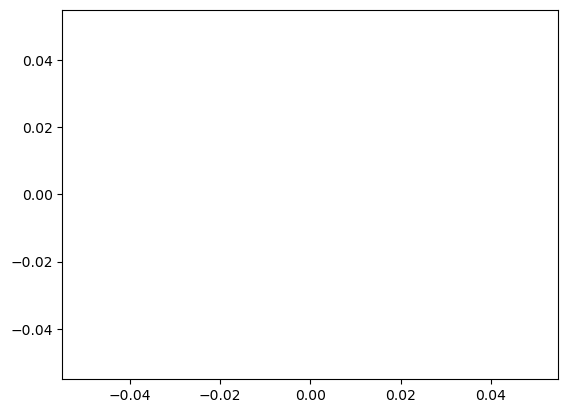

In [10]:
plt.plot(average_loss_all)

In [46]:
bl_model.layers[4].summary()

Model: "sequential_1892"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_scale_shift_3784 (ConvS (None, 50, 50, 64)        1792      
_________________________________________________________________
max_pooling2d_2838 (MaxPooli (None, 25, 25, 64)        0         
_________________________________________________________________
conv_scale_shift_3785 (ConvS (None, 25, 25, 64)        106624    
_________________________________________________________________
max_pooling2d_2839 (MaxPooli (None, 12, 12, 64)        0         
_________________________________________________________________
conv_scale_shift_3786 (ConvS (None, 12, 12, 128)       82176     
_________________________________________________________________
max_pooling2d_2840 (MaxPooli (None, 6, 6, 128)         0         
_________________________________________________________________
conv_scale_shift_3787 (ConvS (None, 6, 6, 128)     

In [47]:
mtl_model.layers[4].summary()

Model: "sequential_1918"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_scale_shift_3836 (ConvS (None, 50, 50, 64)        1792      
_________________________________________________________________
max_pooling2d_2877 (MaxPooli (None, 25, 25, 64)        0         
_________________________________________________________________
conv_scale_shift_3837 (ConvS (None, 25, 25, 64)        106624    
_________________________________________________________________
max_pooling2d_2878 (MaxPooli (None, 12, 12, 64)        0         
_________________________________________________________________
conv_scale_shift_3838 (ConvS (None, 12, 12, 128)       82176     
_________________________________________________________________
max_pooling2d_2879 (MaxPooli (None, 6, 6, 128)         0         
_________________________________________________________________
conv_scale_shift_3839 (ConvS (None, 6, 6, 128)     

In [54]:
print(best_model.layers[4].get_weights()[5])

[[[[1.0000874  0.99893206 1.0001563  ... 0.9996221  0.9992333
    1.0000273 ]
   [0.99987626 0.9999456  1.0001012  ... 1.0001801  0.9998661
    1.0001048 ]
   [1.0002925  1.0002121  1.000228   ... 1.000245   1.0004778
    1.0009093 ]
   ...
   [0.9998015  0.99976826 1.0010911  ... 0.9989558  0.99965173
    1.0004842 ]
   [0.9998005  0.9999852  0.9999319  ... 1.0001477  0.99908006
    1.0000204 ]
   [1.0002916  1.0003986  0.99983126 ... 0.99994355 0.9996564
    0.9998736 ]]]]


In [48]:
print(mtl_model.layers[4].get_weights()[2])

[[[[ 0.06051897 -0.00625105  0.00506146 ... -0.05880547 -0.00956338
    -0.02268306]]

  [[-0.00309567  0.04085363  0.04250082 ... -0.08519962  0.03906929
    -0.01095367]]

  [[ 0.04084228 -0.08691151  0.06347911 ... -0.04012352  0.02766546
     0.0229894 ]]

  [[ 0.08597732 -0.21578102  0.05692383 ... -0.08745253  0.02860547
     0.02172967]]

  [[ 0.0372591  -0.21662705  0.00260276 ... -0.1120059  -0.46663502
    -0.0032398 ]]]


 [[[ 0.07945629  0.05487027  0.07127742 ... -0.06473563  0.0255105
     0.01475979]]

  [[ 0.07074746 -0.01686206  0.09176777 ... -0.0905656   0.06298482
    -0.00614519]]

  [[-0.00946323  0.05567485  0.03018627 ... -0.03779344  0.0326176
     0.01907972]]

  [[-0.07153015  0.01600588  0.0451411  ... -0.03916595  0.04417041
     0.0887928 ]]

  [[-0.01126463 -0.13942723 -0.09822421 ... -0.03706196 -0.36187834
     0.0414549 ]]]


 [[[-0.04201421 -0.04141825  0.04818582 ... -0.06344835 -0.0353003
    -0.05290755]]

  [[-0.006019   -0.01545149  0.08450299 ..

In [10]:
os.chdir('/home/manhducnmd/pp_dijet/Model_results')    
test_model = CWoLA(25, trable = False, conv_trable = False)
test_model.load_weights(f'weights_mtl_dd10_{p_1}')
initial_model = CWoLA(25, trable = False, conv_trable = False)
initial_model.load_weights(f'/home/manhducnmd/pp_dijet/Model_results/weights_pt_dd10_{p_1}')


In [11]:
print(test_model.layers[4].get_weights())

[array([ 1.0288100e-03, -6.6917296e-04, -3.2300509e-03, -4.4228992e-04,
       -1.5400096e-03,  2.6726783e-03, -4.3891405e-04,  3.2858872e-03,
       -2.5953588e-03,  1.5260309e-03, -1.7987353e-03, -2.6453345e-03,
       -2.0224336e-03, -2.9083823e-03, -1.3090099e-03,  2.0106006e-03,
        2.5640875e-03, -1.4459892e-03, -3.0002315e-03,  2.6640627e-03,
       -1.8377497e-03, -2.4628330e-03, -1.3390346e-03, -1.7236659e-03,
       -6.1157753e-04, -1.5215250e-03, -1.9320898e-03, -2.0141680e-04,
       -5.5695465e-04, -2.2967511e-03, -3.2531423e-03, -3.0803215e-03,
        3.1272386e-05, -1.2565338e-03,  2.5270458e-03, -2.5004228e-03,
        3.0400821e-03, -1.5412035e-03, -1.4786550e-05, -1.6160309e-03,
       -3.1027477e-03,  1.1865763e-03, -2.3291777e-03,  2.5426579e-04,
       -2.3803283e-03, -8.2564109e-04, -1.8267024e-03, -2.1404466e-03,
        1.9253303e-03, -4.2604411e-04,  3.3666103e-04,  2.9500267e-03,
        1.6082155e-03, -1.7180553e-03, -1.3181849e-03, -1.5323497e-03,
     

In [12]:
print(initial_model.layers[4].get_weights())

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1.]]]], dtype=float32), array([[[[ 5.49082235e-02, -1.81777403e-01, -6.04940116e-01, ...,
          -6.49320707e-02, -1.11150660e-01,  4.05093059e-02]],

        [[-9.21174139e-02, -4.41086739e-02, -5.66945136e-01, ...,
           2.34861225e-02,  6.50384128e-02,  1.28547205e-02]],

        [[ 1.23540387e-01, -9.26939249e-01, -4.94111389e-01, ...,
           3.65246646e-02,  8.64241943e-02, -2

In [10]:
# Fine-tuning on data
n_train_sr_bkg = 50000
n_train_sr_bkg_ft = 25000
mean_results = []
std_results = []
n_test_sr_bkg = 20000
for p_1 in [25]:#[25,50,75]:
    rng = np.random.default_rng(seed=42)
    os.chdir('/home/manhducnmd/pp_dijet/Model_results')    
    loaded_model = CWoLA(p_1, trable = False, conv_trable = False)   
    redundant_model = CWoLA(p_1, trable = False, conv_trable = False)
    loaded_model.load_weights(f'weights_ht_dd10_{p_1}')
    loaded_model.layers[5].set_weights(redundant_model.layers[5].get_weights())    
    
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')   
    
    bkg_sr_jet_1 = np.load(f'background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'background_images_sb_{p_1}_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg_ft = int(np.round(n_train_sr_bkg_ft*sb_sr_bkg))
    #First jet, background, SR
    bkg_pretrain_sr_1 = bkg_sr_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SR
    bkg_pretrain_sr_2 = bkg_sr_jet_2[0:-n_test_sr_bkg]
    #First jet, background, SB
    bkg_pretrain_sb_1 = bkg_sb_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SB
    bkg_pretrain_sb_2 = bkg_sb_jet_2[0:-n_test_sr_bkg]
    
    signal_sr_jet_1 = np.load(f'dd10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'dd10_sr_{p_1}_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'dd10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'dd10_sb_{p_1}_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [900]:#[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_pretrain_sr_1 = signal_sr_jet_1[0:20000]
        
        #Second jet, signal, SR
        signal_pretrain_sr_2 = signal_sr_jet_2[0:20000]

        #First jet, signal, SB
        signal_pretrain_sb_1 = signal_sb_jet_1[0:20000]

        #Second jet, signal, SB
        signal_pretrain_sb_2 = signal_sb_jet_2[0:20000]
        
        rng_2 = np.random.default_rng(seed=42)
        rng_3 = np.random.default_rng(seed=42)

        for i in range(1):
            indices_2 = rng_2.permutation(np.shape(bkg_pretrain_sr_1)[0])
            indices_3 = rng_3.permutation(np.shape(signal_pretrain_sr_1)[0])
            
            #First jet, background, SR
            bkg_train_sr_1 = (bkg_pretrain_sr_1[indices_2])[0:n_train_sr_bkg_ft]
            #Second jet, background, SR
            bkg_train_sr_2 = (bkg_pretrain_sr_2[indices_2])[0:n_train_sr_bkg_ft]
            #First jet, background, SB
            bkg_train_sb_1 = (bkg_pretrain_sb_1[indices_2])[0:n_train_sb_bkg_ft]
            #Second jet, background, SB
            bkg_train_sb_2 = (bkg_pretrain_sb_2[indices_2])[0:n_train_sb_bkg_ft]

            signal_train_sr_1 = (signal_pretrain_sr_1[indices_3])[0:n_train_sr_signal]
            #Second jet, background, SR
            signal_train_sr_2 = (signal_pretrain_sr_2[indices_3])[0:n_train_sr_signal]
            #First jet, background, SB
            signal_train_sb_1 = (signal_pretrain_sb_1[indices_3])[0:n_train_sb_signal]
            #Second jet, background, SB
            signal_train_sb_2 = (signal_pretrain_sb_2[indices_3])[0:n_train_sb_signal]

            train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)

            train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
            train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))
            train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)

            x_train_1 = np.concatenate((train_sr_1, train_sb_1))
            x_train_2 = np.concatenate((train_sr_2, train_sb_2))
            y_train = np.concatenate((train_label_sr, train_label_sb))

            #Mix up the samples
            indices = rng.permutation(np.shape(y_train)[0])
            x_train_1 = x_train_1[indices]
            x_train_2 = x_train_2[indices]
            y_train = y_train[indices]

            x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
            x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))

            print(f'Training with significance = {significance:.2f}, run {i}')
            cwola_ft = CWoLA(p_1, trable = True, conv_trable = False)
            cwola_ft.set_weights(loaded_model.get_weights())
            cwola_ft.trainable = True
            cwola_ft.layers[4].trainable = False #Freezing the 4th layer            
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola_ft.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            history = cwola_ft.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
              shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            #cwola_ft.save(f'/home/manhducnmd/pp_dijet/Model_results/ft_run_{i}_dd10_{n_train_sr_signal}_{p_1}.keras')
    

2024-07-23 17:16:41.691043: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2024-07-23 17:16:41.724676: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3200000000 Hz
2024-07-23 17:16:41.727591: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558071625890 executing computations on platform Host. Devices:
2024-07-23 17:16:41.727635: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version
2024-07-23 17:16:41.729456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA GeForce GTX 1080 Ti major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:d8:00.0
2024-07-23 17:16:41.729541: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2024-07-23 17:16:41.729567: I tenso

Training with significance = 5.66, run 0
Train on 41216 samples, validate on 10304 samples
Epoch 1/1000


2024-07-23 17:16:47.386734: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2024-07-23 17:16:47.571746: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-07-23 17:16:48.210125: W tensorflow/stream_executor/cuda/redzone_allocator.cc:312] Not found: ./bin/ptxas not found
Relying on driver to perform ptx compilation. This message will be only logged once.


41216/41216 [==============================] - 5s 125us/sample - loss: 0.7116 - accuracy: 0.5144 - val_loss: 0.6930 - val_accuracy: 0.5138
Epoch 2/1000
41216/41216 [==============================] - 2s 59us/sample - loss: 0.6912 - accuracy: 0.5174 - val_loss: 0.6908 - val_accuracy: 0.5132
Epoch 3/1000
41216/41216 [==============================] - 2s 59us/sample - loss: 0.6904 - accuracy: 0.5179 - val_loss: 0.6910 - val_accuracy: 0.5149
Epoch 4/1000
41216/41216 [==============================] - 2s 59us/sample - loss: 0.6903 - accuracy: 0.5192 - val_loss: 0.6905 - val_accuracy: 0.5161
Epoch 5/1000
41216/41216 [==============================] - 2s 59us/sample - loss: 0.6901 - accuracy: 0.5196 - val_loss: 0.6904 - val_accuracy: 0.5196
Epoch 6/1000
41216/41216 [==============================] - 2s 59us/sample - loss: 0.6897 - accuracy: 0.5213 - val_loss: 0.6904 - val_accuracy: 0.5204
Epoch 7/1000
41216/41216 [==============================] - 2s 58us/sample - loss: 0.6896 - accuracy: 0.52

In [95]:
cwola_ft.layers[4].summary()

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_scale_shift_224 (ConvSc (None, 50, 50, 64)        1792      
_________________________________________________________________
max_pooling2d_168 (MaxPoolin (None, 25, 25, 64)        0         
_________________________________________________________________
conv_scale_shift_225 (ConvSc (None, 25, 25, 64)        106624    
_________________________________________________________________
max_pooling2d_169 (MaxPoolin (None, 12, 12, 64)        0         
_________________________________________________________________
conv_scale_shift_226 (ConvSc (None, 12, 12, 128)       82176     
_________________________________________________________________
max_pooling2d_170 (MaxPoolin (None, 6, 6, 128)         0         
_________________________________________________________________
conv_scale_shift_227 (ConvSc (None, 6, 6, 128)      

In [96]:
print(cwola_ft.layers[4].get_weights())

[array([-0.00081349,  0.00052455, -0.00015339, -0.00085412, -0.00089304,
       -0.00063475, -0.00081319, -0.00065748,  0.00025699, -0.00095475,
       -0.00069215, -0.00167613, -0.00081473,  0.00086451, -0.00092645,
        0.0016292 , -0.00083145, -0.00076103, -0.00098947, -0.00072238,
       -0.00066913, -0.00028696, -0.0009172 , -0.0006859 , -0.00096543,
       -0.00166685, -0.00022862, -0.00065516, -0.00089282, -0.00062972,
       -0.00128071, -0.00159532,  0.00051706, -0.00097253, -0.0009642 ,
       -0.00108845, -0.00080036, -0.00073242, -0.00094115,  0.00032069,
        0.00026181, -0.00075679, -0.00093944,  0.00080926, -0.0004939 ,
        0.00160567, -0.00085839, -0.0007062 , -0.00087126,  0.00030216,
        0.0009036 , -0.00035753,  0.00078741, -0.00104904, -0.00061336,
       -0.00076209, -0.00079403, -0.00082153, -0.00078852,  0.00076288,
        0.00065032,  0.00065564, -0.00158137, -0.00101269], dtype=float32), array([[[[0.99996215, 1.0015799 , 0.9988151 , 1.0005362 , 0

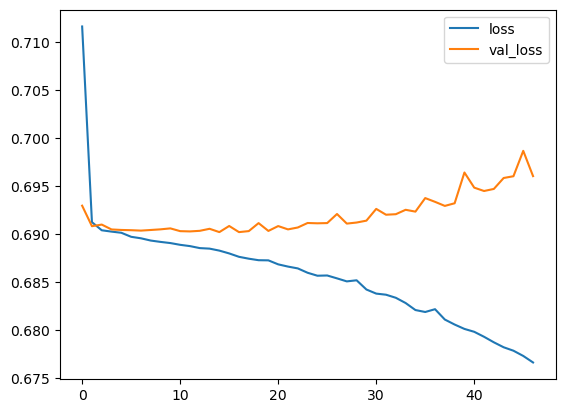

In [11]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc = 'upper right')
plt.show()

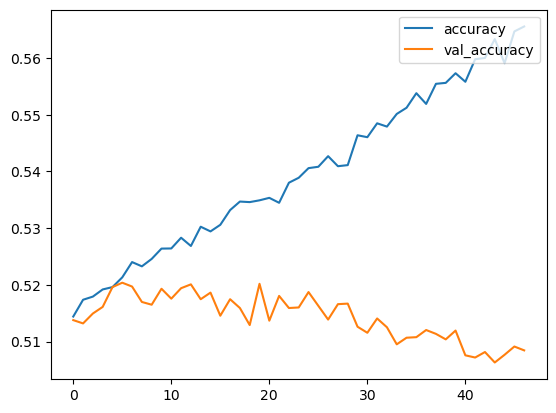

In [12]:
plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper right')
plt.show()

In [15]:
os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')

In [16]:
bkg_sr_jet_1 = np.load('background_images_sr_25_jet_1.npy')
bkg_sr_jet_2 = np.load('background_images_sr_25_jet_2.npy')

signal_sr_jet_1 = np.load('dd10_sr_25_jet_1.npy')
signal_sr_jet_2 = np.load('dd10_sr_25_jet_2.npy')



In [18]:
signal_test_1 = signal_sr_jet_1[-20000:]
signal_test_2 = signal_sr_jet_2[-20000:]

bkg_test_1 = bkg_sr_jet_1[-20000:]
bkg_test_2 = bkg_sr_jet_2[-20000:]


test_label_signal = np.ones(np.shape(signal_test_1)[0])
test_label_bkg = np.zeros(np.shape(bkg_test_1)[0])

x_test_1 = np.concatenate((signal_test_1, bkg_test_1))
x_test_2 = np.concatenate((signal_test_2, bkg_test_2))
y_test = np.concatenate((test_label_signal, test_label_bkg))

x_test_1 = x_test_1.reshape((np.shape(x_test_1)[0],25,25,1))
x_test_2 = x_test_2.reshape((np.shape(x_test_2)[0],25,25,1))


In [19]:
x_predict = cwola_ft.predict([x_test_1, x_test_2])


In [20]:
x_predict_0 = x_predict[y_test == 0]
x_predict_1 = x_predict[y_test == 1]

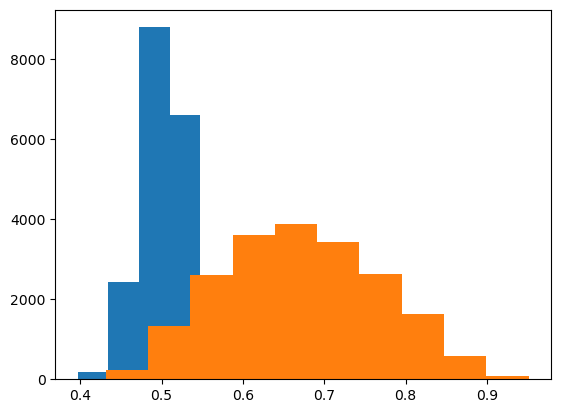

In [21]:
plt.hist(x_predict_0)
plt.hist(x_predict_1)
plt.show()

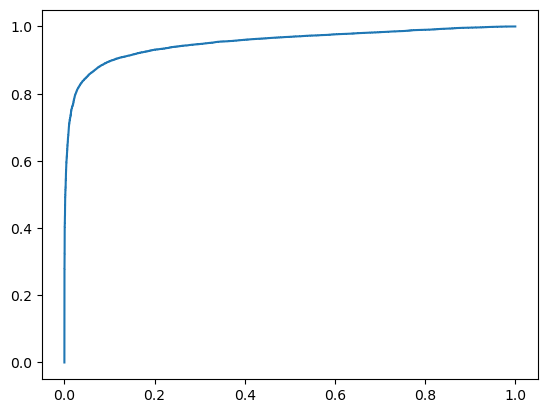

0.95231905375


In [22]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [23]:
print(epsilon_s)

[0.4208     0.70045    0.89594167]


In [24]:
n_train_sr_signal = 900

In [25]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[1]+25000*0.01)*np.log(n_train_sr_signal*epsilon_s[1]/(25000*0.01) + 1) - 
                 n_train_sr_signal*epsilon_s[1])))

30.91780848440995


In [26]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[0]+25000*0.001)*np.log(n_train_sr_signal*epsilon_s[0]/(25000*0.001) + 1) - 
                 n_train_sr_signal*epsilon_s[0])))

38.58410977505668


In [27]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[2]+25000*0.1)*np.log(n_train_sr_signal*epsilon_s[2]/(25000*0.1) + 1) - 
                 n_train_sr_signal*epsilon_s[2])))

15.359238195438198


In [121]:
# Fine-tuning on data
n_train_sr_bkg = 50000
n_train_sr_bkg_ft = 25000
mean_results = []
std_results = []
n_test_sr_bkg = 20000
for p_1 in [75]:
    rng = np.random.default_rng(seed=42)
    os.chdir('/home/manhducnmd/pp_dijet/Model_results')    
    loaded_model = CWoLA(p_1, trable = False, conv_trable = False)   
    redundant_model = CWoLA(p_1, trable = False, conv_trable = False)
    loaded_model.load_weights(f'weights_pt_dd10_{p_1}') 
    #redundant_model.load_weights(f'weights_pt_initial_dd10_{p_1}') 
    loaded_model.layers[5].set_weights(redundant_model.layers[5].get_weights())    
    os.chdir(r'/home/manhducnmd/pp_dijet/Results_full')   
    
    bkg_sr_jet_1 = np.load(f'background_images_sr_{p_1}_jet_1.npy')
    bkg_sr_jet_2 = np.load(f'background_images_sr_{p_1}_jet_2.npy')
    
    bkg_sb_jet_1 = np.load(f'background_images_sb_{p_1}_jet_1.npy')
    bkg_sb_jet_2 = np.load(f'background_images_sb_{p_1}_jet_2.npy')
    
    sb_sr_bkg = np.shape(bkg_sb_jet_1)[0]/np.shape(bkg_sr_jet_2)[0]
    n_train_sb_bkg_ft = int(np.round(n_train_sr_bkg_ft*sb_sr_bkg))
    #First jet, background, SR
    bkg_pretrain_sr_1 = bkg_sr_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SR
    bkg_pretrain_sr_2 = bkg_sr_jet_2[0:-n_test_sr_bkg]
    #First jet, background, SB
    bkg_pretrain_sb_1 = bkg_sb_jet_1[0:-n_test_sr_bkg]
    #Second jet, background, SB
    bkg_pretrain_sb_2 = bkg_sb_jet_2[0:-n_test_sr_bkg]
    
    signal_sr_jet_1 = np.load(f'dd10_sr_{p_1}_jet_1.npy')
    signal_sr_jet_2 = np.load(f'dd10_sr_{p_1}_jet_2.npy')
    
    signal_sb_jet_1 = np.load(f'dd10_sb_{p_1}_jet_1.npy')
    signal_sb_jet_2 = np.load(f'dd10_sb_{p_1}_jet_2.npy')
    
    sb_sr_signal = np.shape(signal_sb_jet_1)[0]/np.shape(signal_sr_jet_1)[0]
    for n_train_sr_signal in [900]:#[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]:
        significance = np.sqrt(2*((n_train_sr_signal+25000)*np.log(n_train_sr_signal/25000 + 1) - n_train_sr_signal))
        
        n_train_sb_signal = int(np.round(n_train_sr_signal*sb_sr_signal))
        n_test_sr_signal = 20000
        
        #First jet, signal, SR
        signal_pretrain_sr_1 = signal_sr_jet_1[0:20000]
        
        #Second jet, signal, SR
        signal_pretrain_sr_2 = signal_sr_jet_2[0:20000]

        #First jet, signal, SB
        signal_pretrain_sb_1 = signal_sb_jet_1[0:20000]

        #Second jet, signal, SB
        signal_pretrain_sb_2 = signal_sb_jet_2[0:20000]
        
        rng_2 = np.random.default_rng(seed=42)
        rng_3 = np.random.default_rng(seed=42)

        for i in range(1):
            indices_2 = rng_2.permutation(np.shape(bkg_pretrain_sr_1)[0])
            indices_3 = rng_3.permutation(np.shape(signal_pretrain_sr_1)[0])
            
            #First jet, background, SR
            bkg_train_sr_1 = (bkg_pretrain_sr_1[indices_2])[0:n_train_sr_bkg_ft]
            #Second jet, background, SR
            bkg_train_sr_2 = (bkg_pretrain_sr_2[indices_2])[0:n_train_sr_bkg_ft]
            #First jet, background, SB
            bkg_train_sb_1 = (bkg_pretrain_sb_1[indices_2])[0:n_train_sb_bkg_ft]
            #Second jet, background, SB
            bkg_train_sb_2 = (bkg_pretrain_sb_2[indices_2])[0:n_train_sb_bkg_ft]

            signal_train_sr_1 = (signal_pretrain_sr_1[indices_3])[0:n_train_sr_signal]
            #Second jet, background, SR
            signal_train_sr_2 = (signal_pretrain_sr_2[indices_3])[0:n_train_sr_signal]
            #First jet, background, SB
            signal_train_sb_1 = (signal_pretrain_sb_1[indices_3])[0:n_train_sb_signal]
            #Second jet, background, SB
            signal_train_sb_2 = (signal_pretrain_sb_2[indices_3])[0:n_train_sb_signal]

            train_sr_1 = np.concatenate((signal_train_sr_1, bkg_train_sr_1))
            train_sr_2 = np.concatenate((signal_train_sr_2, bkg_train_sr_2))
            train_label_sr = np.ones(np.shape(train_sr_1)[0], dtype = int)

            train_sb_1 = np.concatenate((signal_train_sb_1, bkg_train_sb_1))
            train_sb_2 = np.concatenate((signal_train_sb_2, bkg_train_sb_2))
            train_label_sb = np.zeros(np.shape(train_sb_1)[0], dtype = int)

            x_train_1 = np.concatenate((train_sr_1, train_sb_1))
            x_train_2 = np.concatenate((train_sr_2, train_sb_2))
            y_train = np.concatenate((train_label_sr, train_label_sb))

            #Mix up the samples
            indices = rng.permutation(np.shape(y_train)[0])
            x_train_1 = x_train_1[indices]
            x_train_2 = x_train_2[indices]
            y_train = y_train[indices]

            x_train_1 = x_train_1.reshape((np.shape(x_train_1)[0], p_1, p_1, 1))
            x_train_2 = x_train_2.reshape((np.shape(x_train_2)[0], p_1, p_1, 1))

            print(f'Training with significance = {significance:.2f}, run {i}')
            cwola_ft = CWoLA(p_1, trable = False, conv_trable = False)
            cwola_ft.set_weights(loaded_model.get_weights())
            cwola_ft.trainable = True
            cwola_ft.layers[4].trainable = False #Freezing the 4th layer            
            loss_object = keras.losses.BinaryCrossentropy()
            optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
            cwola_ft.compile(loss = loss_object, optimizer = optimizer, metrics = ['accuracy'])
            early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=30, restore_best_weights=True)
            history = cwola_ft.fit({'jet_1': x_train_1, 'jet_2': x_train_2}, y_train, validation_split = 0.2,
              shuffle = True, batch_size = 500, callbacks = [early_stopping], epochs = 1000)  
            #cwola_ft.save_weights(f'/home/manhducnmd/pp_dijet/Model_results/run_{i}_weights_ft_dd10_{n_train_sr_signal}_{p_1}')            
    

KeyboardInterrupt: 

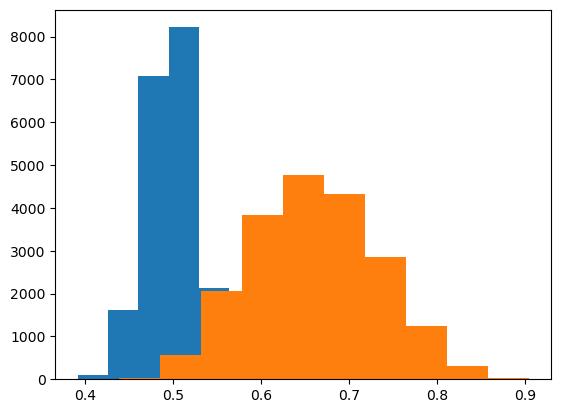

In [117]:
plt.hist(x_predict_0)
plt.hist(x_predict_1)
plt.show()

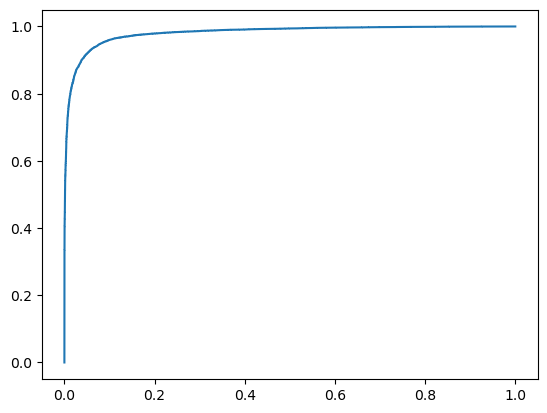

0.9810163662500001


In [118]:
fpr, tpr, th = roc_curve(y_test, x_predict)
plt.plot(fpr, tpr)
plt.show()
f = interpolate.interp1d(fpr, tpr)
epsilon_s = f([0.001, 0.01, 0.1])
print(roc_auc_score(y_test, x_predict))

In [120]:
print(np.sqrt(2*((n_train_sr_signal*epsilon_s[0]+25000*0.001)*np.log(n_train_sr_signal*epsilon_s[0]/(25000*0.001) + 1) - 
                 n_train_sr_signal*epsilon_s[0])))

40.51212593956609
